# Trabajo final Series Temporales

Comenzamos cargando las librarias necesarias

In [6]:
import openpyxl
import seaborn as sns
sns.set(rc={'figure.figsize':(11, 4)})
import statsmodels.api as sm
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
from sktime.transformations.series.boxcox import LogTransformer
# Sktime fucntions
# Forecast horizon and Split function 
from sktime.forecasting.base import ForecastingHorizon
from sktime.forecasting.model_selection import temporal_train_test_split
# Autocorrelation Fuction Package
from sktime.utils.plotting import plot_series
from sktime.forecasting.naive import NaiveForecaster
from sktime.forecasting.arima import AutoARIMA
from sktime.forecasting.ets import AutoETS
# Sktime fucntions
# Forecast Accuracy MAPE & MSE & RMSE
from sktime.performance_metrics.forecasting import mean_absolute_percentage_error
from sktime.performance_metrics.forecasting import MeanSquaredError
from sklearn.metrics import r2_score
import warnings
import pandas as pd
import numpy as np
from sklearn import metrics
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from prophet import Prophet

Cargamos ahora los datos correspondientes

In [7]:
df_h = pd.read_excel('DemandaEnergia.xlsx', sheet_name='Hourly Data')
df_d=pd.read_excel('DemandaEnergia.xlsx', sheet_name='Daily Data')

Realizamos una primera observación de los datos

In [8]:
df_h.head()

,Region,UTC time,Local date,Local hour,Local time,Time zone,D
0,CAL,2015-07-01 08:00:00,2015-07-01,1,2015-07-01 01:00:00,Pacific,38210
1,CAL,2015-07-01 09:00:00,2015-07-01,2,2015-07-01 02:00:00,Pacific,35171
2,CAL,2015-07-01 10:00:00,2015-07-01,3,2015-07-01 03:00:00,Pacific,33243
3,CAL,2015-07-01 11:00:00,2015-07-01,4,2015-07-01 04:00:00,Pacific,31955
4,CAL,2015-07-01 12:00:00,2015-07-01,5,2015-07-01 05:00:00,Pacific,31199


In [9]:
df_d.head()

,Region,Local date,Time zone,D
0,CAL,2015-07-01,Pacific,978699
1,CAL,2015-07-02,Pacific,962751
2,CAL,2015-07-03,Pacific,887079
3,CAL,2015-07-04,Pacific,830874
4,CAL,2015-07-05,Pacific,791310


Realizamos los cambios pertinentes para tener los datos en el formato necesario

In [10]:
df_h=df_h.loc[:,['Local time','D']]
df_h = df_h.rename(columns={'Local time': 'ds', 'D': 'y'})
#En un primer vistazo de los datos observo duplicados y decido agruparlos sumandolos
df_h=df_h.groupby(["ds"]).sum()
df_h= df_h.asfreq('h')

In [11]:
df_d=df_d.loc[:,['Local date','D']]
df_d = df_d.rename(columns={'Local date': 'ds', 'D': 'y'})
df_d=df_d.groupby(["ds"]).sum()
df_d= df_d.asfreq('D')

Vamos a comprobar si los datos son los mismos, es decir que si realizamos la suma de datos horarios obtenemos la suma de datos semanales.

In [12]:
df_h.resample('D').sum().head()

,y
ds,
2015-07-01,939154.0
2015-07-02,963914.0
2015-07-03,888068.0
2015-07-04,833577.0
2015-07-05,792090.0


Los datos no coinciden, hay que tener en cuenta que en los datos originales en el caso diario los datos comienzan a la 01 a.m. mientras que en los datos horarios comienzan a las 00 a.m.

# Predicciones horarias

Vamos a estudiar cada tipo de datos por separado, comenzamos con los datos horarios

Comenzamos ploteando todos los datos

<AxesSubplot:xlabel='ds'>

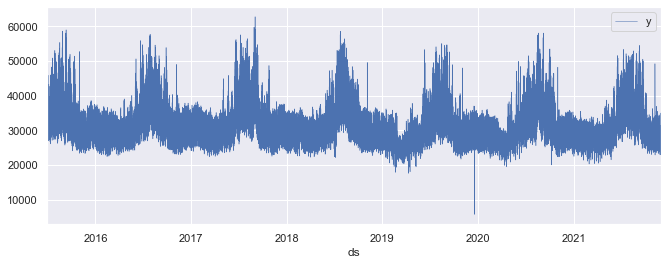

In [13]:
df_h.plot(linewidth=0.5)

Como tenemos un gran número de observaciones y observamos que los datos no varian en exceso de unos años a otros, vamos a observar los datos del último año 2021

Destacar que se trata de una serie claramente estacional

In [14]:
df_2021=df_h.loc['2021']

Gráficamos ahora los datos correspondientes a 2021

<AxesSubplot:xlabel='ds'>

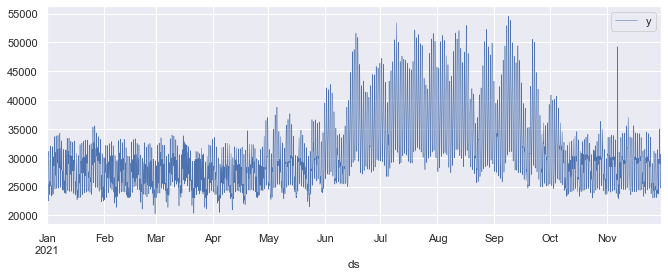

In [15]:
df_2021.plot(linewidth=0.5)

Observamos si hay algún valor nulo para poder realizar posteriormente la gráfica de las componentes estacionales

In [16]:
df_2021.isna()[df_2021.isna().y==True]

,y
ds,
2021-03-14 02:00:00,True


Tenemos un valor NA el dia 14 de marzo a las 2 a.m le damos el valor promedio entre la hora anterior y siguiente.

In [17]:
df_h.loc['2021/03/14 02'].y=sum([df_h.loc['2021/03/14 01'].y,df_h.loc['2021/03/14 03'].y])/2

Realizamos ahora el gráfico de las componentes 

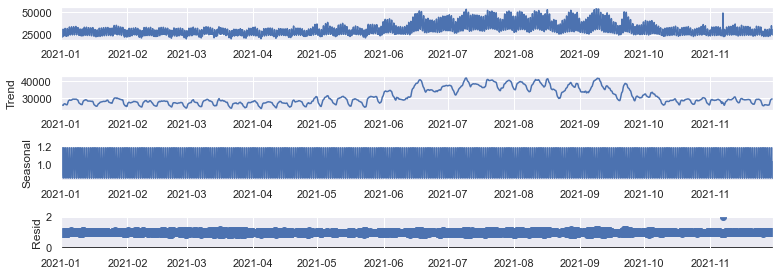

In [18]:
decomposition = seasonal_decompose(df_h.loc['2021'], 
                                   model='multiplicative', 
                                   period=24)
decomposition.plot();

Quitando los meses del verano los datosson bastante similares, se observa una gran estacionalidad y no se observa tendencia.
Como tenemos una gran cantidad de datos al ser datos horarios vamos a tratar de realizar nuestras predicciones tomando unicamente los datos de noviembre de 2021.

In [19]:
df_h_Nov_21=df_h.loc['2021-11']

Representamos el mes de noviembre.

<AxesSubplot:xlabel='ds'>

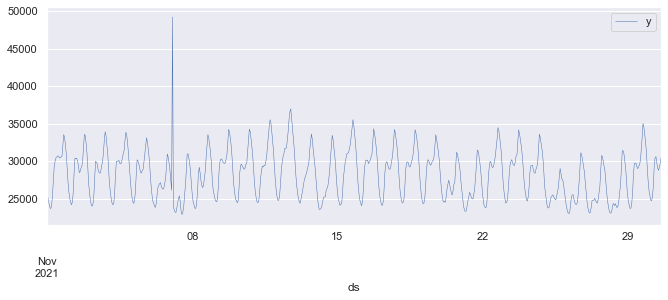

In [20]:
df_h_Nov_21.plot(linewidth=0.5)

A simple vista no puedo determinar si nuestra serie es o no estacionaria en varianza, por tanto realizo la prueba de Dickey fuller aumentada

In [21]:
adf=adfuller(df_h_Nov_21, maxlag=1)
print('El T-test es:', adf[0])

El T-test es: -7.34881319971191


In [22]:
print('El P-value es:', adf[1])
print('Valores críticos:', adf[4])

El P-value es: 1.0187324586873567e-10
Valores críticos: {'1%': -3.439593802573824, '5%': -2.865619356068967, '10%': -2.568942332870462}


Como nuestro valor T-test es mucho menos que los valores críticos y el p-valor es muy pequeño podemos decir que la serie es estacionaria y por tanto no sera necesario realizarle ninguna transformación a nuestros datos.

Separamos nuestros datos en conjunto de test y conjunto de entrenamiento

544 168


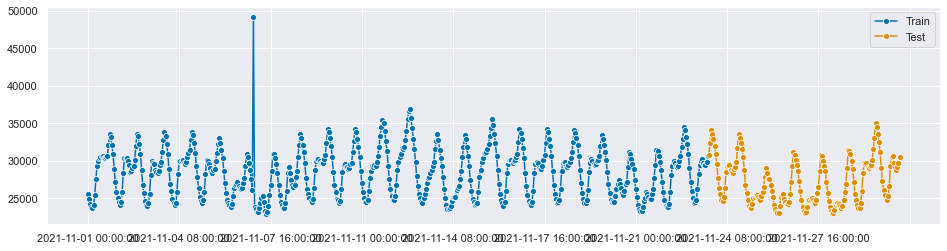

In [23]:
# Select Train & test sample
# we will try to forecast y_test from y_train
# plotting for illustration
# original and log samples
y_train, y_test = temporal_train_test_split(y =df_h_Nov_21, test_size=168)
plot_series(y_train, y_test, labels=["Train", "Test"])
# Time Series Size
print(y_train.shape[0], y_test.shape[0])

Se observa un valor atipico,un impulso, vamos a estudiarlo de manera independiente

In [24]:
df_h_Nov_21_2=df_h_Nov_21.copy()

In [25]:
df_h_Nov_21_2.describe().T

,count,mean,std,min,25%,50%,75%,max
y,712.0,28248.69382,3208.506918,22861.0,25268.75,28624.0,30438.75,49229.0


Buscamos en que fecha obtuvimos dicho máximo.

In [26]:
df_h_Nov_21_2[df_h_Nov_21_2.y==49229]

,y
ds,
2021-11-07 01:00:00,49229.0


Como se trata de un momento puntual muy concreto, voy a cambiarlo por la mediana de ese dia

In [27]:
df_h_Nov_21_2[df_h_Nov_21_2.y==49229]=df_h_Nov_21_2.loc['2021-11-07'].median()

Realizo la separación en train y test corresponiente, lo que hare sera estudiar uno de los modelos con esta intervencion en el valor atipico y sin ella y me quedare con los datos con los que mejores resultados obtenga. Probablemente la diferencia no sea mucha puesto que se trata de una única observación de las 720 observaciones que tenemos del mes de noviemrbe

544 168


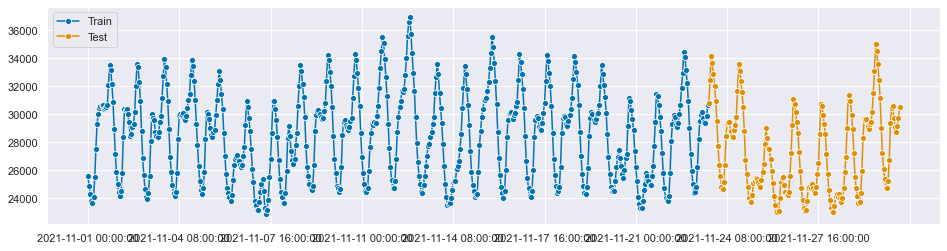

In [28]:
# Select Train & test sample
# we will try to forecast y_test from y_train
# plotting for illustration
# original and log samples
y_train2, y_test2 = temporal_train_test_split(y =df_h_Nov_21_2, test_size=168)
plot_series(y_train2, y_test2, labels=["Train", "Test"])
# Time Series Size
print(y_train2.shape[0], y_test2.shape[0])

Vamos a ver si existe estacionalidad a simple vista como parece apreciarse en la representación del mes de Noviembre, representamos los 3 primeros dias y en efecto observamos que existe esa estacionalidad

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

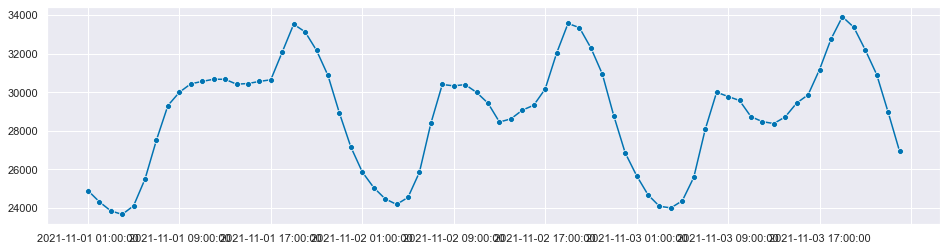

In [29]:
plot_series(y_train[1:24*3+1])

## Modelo a batir

Tras comprobar que existe estacionalidad tomamos como modelo a batir el modelo ingenuo o naïve estacional con periodicidad 24

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

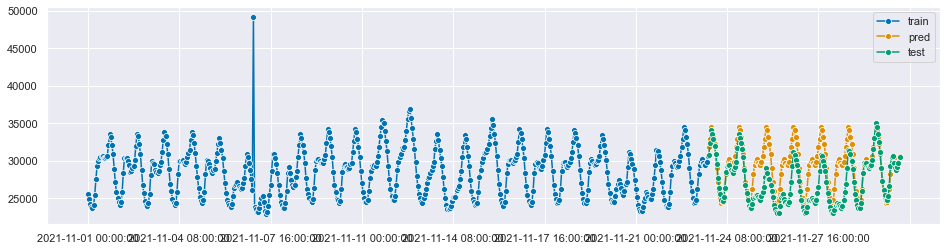

In [30]:
fh = np.arange(len(y_test)) + 1
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=24) #tomamos modelo naive estacional

# step 4: fitting the forecaster
forecaster.fit(y_train)

# step 5: querying predictions
y_predNaive = forecaster.predict(fh)

# optional: plotting predictions and past data
plot_series(y_train, y_predNaive, y_test, labels=["train","pred", "test"])

Parece que obtenemos buenas predicciones, vamos a calcular el error

In [31]:
# Forecast Accuracy
#Root Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_NAIVE=rmse(y_test, y_predNaive)
# MAPE
MAPE_NAIVE=mean_absolute_percentage_error(y_test, y_predNaive)
print(RMSE_NAIVE,MAPE_NAIVE)

2888.675470901928 0.07732211237084259


Probamos ahora con los datos tras intervenir el valor atípico comentado

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

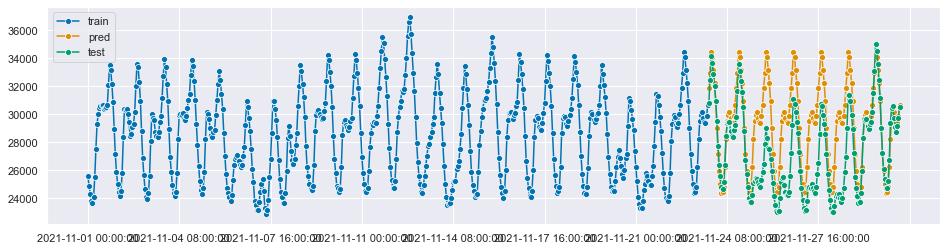

In [32]:
fh2 = np.arange(len(y_test2)) + 1
# step 3: specifying the forecasting algorithm
forecaster = NaiveForecaster(strategy="last", sp=24) #tomamos modelo naive estacional

# step 4: fitting the forecaster
forecaster.fit(y_train2)

# step 5: querying predictions
y_predNaive2 = forecaster.predict(fh2)

# optional: plotting predictions and past data
plot_series(y_train2, y_predNaive2, y_test2, labels=["train","pred", "test"])

Calculamos ahora los errores de este modelo

In [33]:
# Forecast Accuracy
#Root Mean Squared Error
RMSE_NAIVE2=rmse(y_test2, y_predNaive2)
# MAPE
MAPE_NAIVE2=mean_absolute_percentage_error(y_test2, y_predNaive2)
print(RMSE_NAIVE2,MAPE_NAIVE2)

2888.675470901928 0.07732211237084259


Observo que ese valor atipico no afecta a nuestras prediciones así que decido continuar con los datos originales

## Autoarima

In [34]:
forecasterARIMA = AutoARIMA(sp=24,suppress_warnings=True)
forecasterARIMA.fit(y_train)

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:1899: RuntimeWarning: invalid value encountered in reciprocal
  return np.roots(self.polynomial_reduced_ar)**-1
C:\Users\malon\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py:38: RuntimeWarning: invalid value encountered in true_divide
  max_invroot = max(0, *np.abs(1 / model.arroots()))
C:\Users\malon\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(2,0,0)(1,0,1)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)
C:\Users\malon\AppData\Roaming\Python\Python39\site-packages\pmdarima\arima\_auto_solvers.py:522: ModelFitWarning: Error fitting  ARIMA(3,0,1)(2,0,0)[24] intercept (if you do not want to see these warnings, run with error_action="ignore").
  warnings.warn(warning_str, ModelFitWarning)


AutoARIMA(sp=24, suppress_warnings=True)

In [35]:
# Auto ARIMA Model Summary
print(forecasterARIMA.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  544
Model:             SARIMAX(2, 0, 0)x(2, 0, 0, 24)   Log Likelihood               -4778.813
Date:                            Sat, 15 Jan 2022   AIC                           9569.626
Time:                                    10:14:34   BIC                           9595.420
Sample:                                         0   HQIC                          9579.711
                                            - 544                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept   4610.9650    682.490      6.756      0.000    3273.308    5948.622
ar.L1          0.4948      0.015   

In [36]:
fh = np.arange(len(y_test)) + 1

In [37]:
# Auto ARIMA Forecast (log)
ARIMA_pred= forecasterARIMA.predict(fh)
ARIMA_pred

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,y
2021-11-23 16:00:00,30674.356353
2021-11-23 17:00:00,31087.322870
2021-11-23 18:00:00,31737.340136
2021-11-23 19:00:00,31421.937336
2021-11-23 20:00:00,30865.262851
...,...
2021-11-30 11:00:00,28811.950803
2021-11-30 12:00:00,28804.451472
2021-11-30 13:00:00,28804.258224
2021-11-30 14:00:00,28821.587138


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

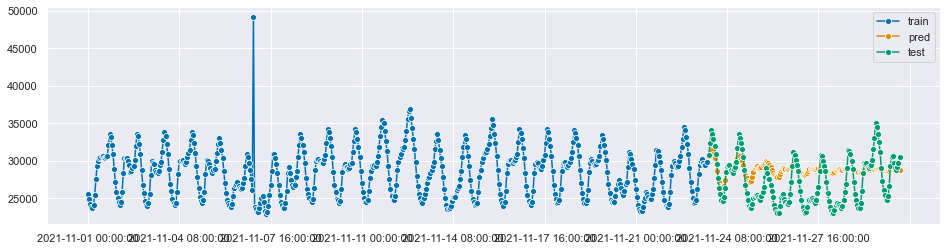

In [38]:
plot_series(y_train,ARIMA_pred,y_test, labels=["train","pred", "test"] )

No parecen muy buenas predicciones vamos a probar con la transformación logaritmica lo que provocara que los datos tengan una estacionariedad más fuerte

In [39]:
# Apply Log Transformer
transformer = LogTransformer()
log_df_h_Nov_21= transformer.fit_transform(df_h_Nov_21)
log_df_h_Nov_21.tail()

,y
ds,
2021-11-30 11:00:00,10.277393
2021-11-30 12:00:00,10.267054
2021-11-30 13:00:00,10.281239
2021-11-30 14:00:00,10.299542
2021-11-30 15:00:00,10.325875


In [40]:
log_y_train, log_y_test = temporal_train_test_split(y =log_df_h_Nov_21, test_size=168)

In [41]:
forecasterARIMAL = AutoARIMA(sp=24,suppress_warnings=True)
forecasterARIMAL.fit(log_y_train)

AutoARIMA(sp=24, suppress_warnings=True)

In [42]:
# Auto ARIMA Model Summary
print(forecasterARIMAL.summary())

                                        SARIMAX Results                                        
Dep. Variable:                                       y   No. Observations:                  544
Model:             SARIMAX(1, 0, 1)x(2, 0, [1, 2], 24)   Log Likelihood                 914.514
Date:                                 Sat, 15 Jan 2022   AIC                          -1813.029
Time:                                         10:17:00   BIC                          -1778.637
Sample:                                              0   HQIC                         -1799.583
                                                 - 544                                         
Covariance Type:                                   opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept      0.5553      0.261      2.125      0.034       0.043       1

In [43]:
# Auto ARIMA Forecast (log)
log_y_pred= forecasterARIMAL.predict(fh)
ARIMA_predL=np.exp(log_y_pred)
ARIMA_predL

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,y
2021-11-23 16:00:00,30780.709009
2021-11-23 17:00:00,31352.095205
2021-11-23 18:00:00,32195.972849
2021-11-23 19:00:00,31758.542964
2021-11-23 20:00:00,31068.629272
...,...
2021-11-30 11:00:00,28084.042009
2021-11-30 12:00:00,28031.711737
2021-11-30 13:00:00,28035.580912
2021-11-30 14:00:00,28151.039008


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

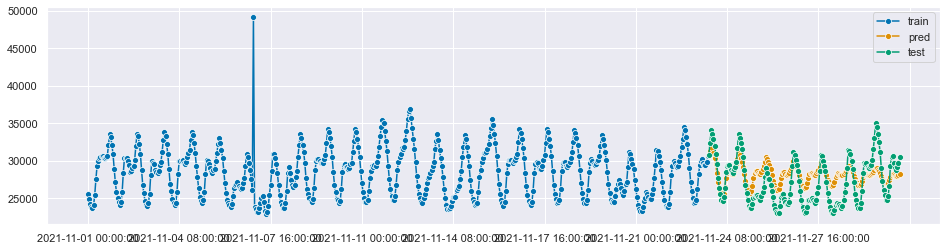

In [44]:
plot_series(y_train,ARIMA_predL,y_test, labels=["train","pred", "test"] )

Vamos a calcular los errores que cometen ambos modelos y asi selecionar el que más nos interese, a simple vista parace que con el modelo logaritmico obtenemos mejores predicciones

In [45]:
# Forecast Accuracy
#Root Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMA=rmse(y_test, ARIMA_pred)
RMSE_ARIMAL=rmse(y_test, ARIMA_predL)
print(RMSE_ARIMA,RMSE_ARIMAL)

3053.030614560327 2437.6322257879783


In [46]:
# Forecast Accuracy
# MAPE
MAPE_ARIMA=mean_absolute_percentage_error(y_test, ARIMA_pred)
MAPE_ARIMAL=mean_absolute_percentage_error(y_test, ARIMA_predL)
print(MAPE_ARIMA,MAPE_ARIMAL)

0.09373329198655674 0.07647974105002


Obtenemos errores menores tomando logaritmos y por tanto seleccionamos este modelo como candidato

## ETS

In [47]:
# specifying the forecasting algorithm
forecasterETS= AutoETS(auto=True, sp=24)

In [48]:
# Auto ETS Model Estimation
forecasterETS.fit(y_train)

AutoETS(auto=True, sp=24)

In [49]:
print(forecasterETS.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  544
Model:                       ETS(MNM)   Log Likelihood               -4676.394
Date:                Sat, 15 Jan 2022   AIC                           9408.787
Time:                        10:17:03   BIC                           9529.158
Sample:                    11-01-2021   HQIC                          9455.848
                         - 11-23-2021   Scale                            0.002
Covariance Type:               approx                                         
                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
smoothing_level         0.9999      0.006    156.373      0.000       0.987       1.012
smoothing_seasonal   5.611e-05        nan        nan        nan         nan         nan
initial_level   

In [50]:
# ETS Forescat
ETS_pred =forecasterETS.predict(fh)
print(ETS_pred)

                                y
2021-11-23 16:00:00  31590.856404
2021-11-23 17:00:00  32792.943052
2021-11-23 18:00:00  34291.608413
2021-11-23 19:00:00  34241.826344
2021-11-23 20:00:00  33317.933731
...                           ...
2021-11-30 11:00:00  30047.435510
2021-11-30 12:00:00  29732.376472
2021-11-30 13:00:00  29712.478733
2021-11-30 14:00:00  30093.368263
2021-11-30 15:00:00  30679.989602

[168 rows x 1 columns]


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

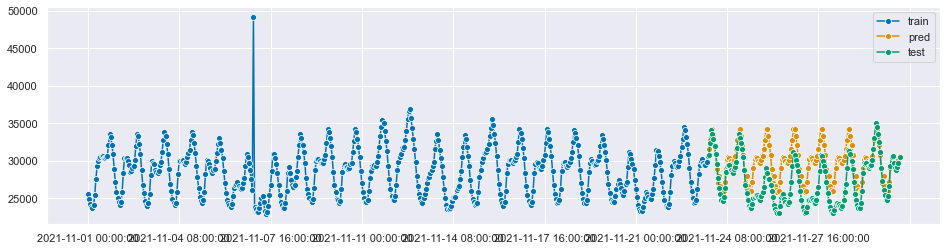

In [51]:
plot_series(y_train,ETS_pred,y_test, labels=["train","pred", "test"] )

## PROPHET

In [16]:
df_h_Nov_p=df_h_Nov_21.rename_axis('ds').reset_index()

In [18]:
# Select Train & test sample
y_trainp, y_testp = temporal_train_test_split(y =df_h_Nov_p, test_size=168)

In [19]:
from prophet import Prophet
m = Prophet()
m.fit(y_trainp)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


In [ ]:
future = m.make_future_dataframe(periods=len(y_testp),freq='H')
forecast = m.predict(future)

In [21]:
a=df_h_Nov_p.shape[0]-168
pred=forecast.loc[a:,'yhat']

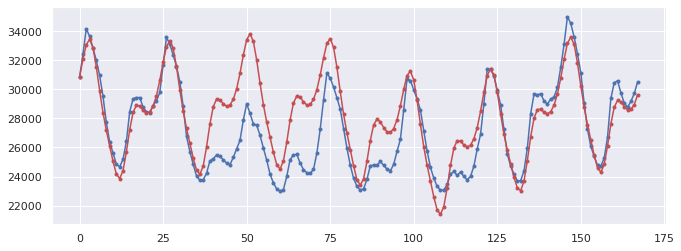

In [ ]:
plt.plot(list(y_testp['y']),'.-')
plt.plot(list(pred),'r.-')
plt.show()

## Comparación técnicas

In [52]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMA=rmse(y_test, ARIMA_predL)
RMSE_ETS=rmse(y_test, ETS_pred)
RMSE_NAIVE=rmse(y_test, y_predNaive)
print(RMSE_ARIMA,RMSE_ETS,RMSE_NAIVE)

2437.6322257879783 3189.2503990779896 2888.675470901928


In [53]:
# Forecast Accuracy
# MAPE
MAPE_ARIMA=mean_absolute_percentage_error(y_test, ARIMA_predL)
MAPE_ETS=mean_absolute_percentage_error(y_test, ETS_pred)
MAPE_NAIVE=mean_absolute_percentage_error(y_test, y_predNaive)
print(MAPE_ARIMA,MAPE_ETS,MAPE_NAIVE)

0.07647974105002 0.09263091314877077 0.07732211237084259


In [ ]:
# Forecast Accuracy Prophet
RMSE_Prophet=rmse(list(y_testp['y']), list(pred))
MAPE_Prophet=mean_absolute_percentage_error(list(y_testp['y']),list(pred))
print(RMSE_Prophet,MAPE_Prophet)

2056.3164926319705 0.05564415607501754


Predice mejor Prophet ya que es la tecnica con la cual obtenemos errores menores

 ## Predicciones horarias 1era Semana Dic21

Tras seleccionar el modelo con menores errores, realizamos las predicciones pedidas

In [ ]:
futurep = m.make_future_dataframe(periods=len(y_testp)+24*7+8,freq='H')
forecastp = m.predict(futurep)

In [ ]:
b=df_h_Nov_p.shape[0]
pred=forecastp.loc[b:,['ds','yhat']]
pred.set_index('ds',inplace = True)

(<Figure size 1152x288 with 1 Axes>,
 <matplotlib.axes._subplots.AxesSubplot at 0x7f13e4d46090>)

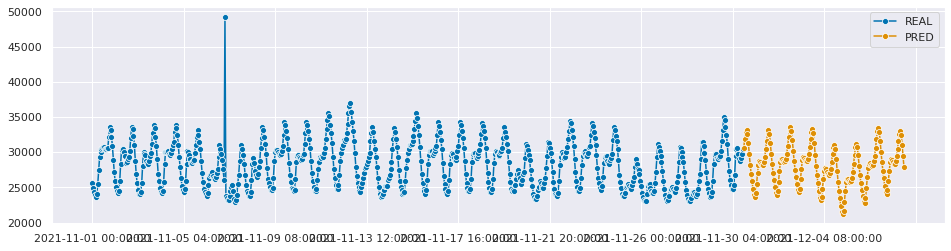

In [ ]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(df_h_Nov_21,pred, labels=["REAL", "PRED"])

In [ ]:
Diciembre=pred[8:].round(4)

In [ ]:
Dh=Diciembre.head(10)

In [ ]:
Dh

,yhat
2021-12-01 00:00:00,26937.6307
2021-12-01 01:00:00,25855.0534
2021-12-01 02:00:00,24804.5616
2021-12-01 03:00:00,23935.3261
2021-12-01 04:00:00,23625.4823
2021-12-01 05:00:00,24167.1539
2021-12-01 06:00:00,25458.5025
2021-12-01 07:00:00,26993.0870
2021-12-01 08:00:00,28171.3648
2021-12-01 09:00:00,28675.1868


In [65]:
Diciembre.to_csv("prediccioneshorarias.csv")

In [66]:
Dh.to_csv("prediccioneshorariashead.csv")

### Anexo: AutoTS

Probamos ahora un paquete de python que analiza varios modelos de series temporales

In [73]:
from autots import AutoTS, load_daily
df = df_h_Nov_21
metric_weighting = {
    'smape_weighting': 1,
    'mae_weighting': 0,
    'rmse_weighting': 1,
    'made_weighting': 0,
    'containment_weighting': 0,
    'runtime_weighting': 0,
    'spl_weighting': 0,
    'contour_weighting': 0,
}
model = AutoTS(
    forecast_length=24*7+10,
    frequency='H',
    prediction_interval=0.9,
    ensemble=None,
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    no_negatives=True,
    max_generations=6,
    num_validations=3,
    metric_weighting=metric_weighting,
    validation_method="seasonal 24"
)
model = model.fit(df)
prediction = model.predict()

Model Number: 1 with model AverageValueNaive in generation 0 of 6
Model Number: 2 with model AverageValueNaive in generation 0 of 6
Model Number: 3 with model AverageValueNaive in generation 0 of 6
Model Number: 4 with model DatepartRegression in generation 0 of 6
Model Number: 5 with model DatepartRegression in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 6 with model DatepartRegression in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 7 with model DatepartRegression in generation 0 of 6
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 6
Model Number: 9 with model ETS in generation 0 of 6
Model Number: 10 with model GLM in generation 0 of 6
Model Number: 11 with model GLM in generation 0 of 6
Model Number: 12 with model GLS in generation 0 of 6
Model Number: 13 with model GLS in generation 0 of 6
Model Number: 14 with model LastValueNaive in generation 0 of 6
Model Number: 15 with model LastValueNaive in generation 0 of 6
Model Number: 16 with model LastValueNaive in generation 0 of 6
Model Number: 17 with model LastValueNaive in generation 0 of 6
Model Number: 18 with model SeasonalNaive in generation 0 of 6
Model Number: 19 with model SeasonalNaive in generation 0 of 6
Model Number: 20 with model SeasonalNaive in generation 0 of 6
Model Number: 21 with model SeasonalNaive 

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encou

Model Number: 34 with model GLS in generation 0 of 6
Model Number: 35 with model SeasonalNaive in generation 0 of 6
Model Number: 36 with model GLM in generation 0 of 6
Model Number: 37 with model ETS in generation 0 of 6
Model Number: 38 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 38: VAR
Model Number: 39 with model VECM in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 39: VECM
Model Number: 40 with model WindowRegression in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 40: WindowRegression
Model Number: 41 with model DatepartRegression in generation 0 of 6
Model Number: 42 with model UnivariateMotif in generation 0 of 6
Model Number: 43 with model MultivariateMotif in generation 0 of 6
Model Number: 44 with model SectionalMotif in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\decomposition\_pca.py:501: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ratio_ = explained_variance_ / total_var
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero enco

Model Number: 45 with model NVAR in generation 0 of 6
Model Number: 46 with model WindowRegression in generation 0 of 6
Model Number: 47 with model MultivariateMotif in generation 0 of 6
Model Number: 48 with model LastValueNaive in generation 0 of 6
Model Number: 49 with model SectionalMotif in generation 0 of 6
Model Number: 50 with model ZeroesNaive in generation 0 of 6
Model Number: 51 with model GLM in generation 0 of 6
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 51: GLM
Model Number: 52 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 52: VAR
Model Number: 53 with model ZeroesNaive in generation 0 of 6
Model Number: 54 with model GLM in generation 0 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 54: GLM
Model Number: 55 with model NVAR in generation 0 of 6
Model Number: 56 with model WindowRegressi

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 57 with model WindowRegression in generation 0 of 6
Model Number: 58 with model WindowRegression in generation 0 of 6
Model Number: 59 with model GLM in generation 0 of 6
Model Number: 60 with model MultivariateMotif in generation 0 of 6
Model Number: 61 with model NVAR in generation 0 of 6
Model Number: 62 with model VECM in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 62: VECM
Model Number: 63 with model AverageValueNaive in generation 0 of 6
Model Number: 64 with model AverageValueNaive in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


Model Number: 65 with model VECM in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 65: VECM
Model Number: 66 with model SectionalMotif in generation 0 of 6
Model Number: 67 with model GLM in generation 0 of 6
Model Number: 68 with model UnivariateMotif in generation 0 of 6
Model Number: 69 with model LastValueNaive in generation 0 of 6
Model Number: 70 with model VECM in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 70: VECM
Model Number: 71 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 71: VAR
Model Number: 72 with model MultivariateMotif in generation 0 of 6
Model Number: 73 with model SeasonalNaive in generation 0 of 6
Model Number: 74 with model UnivariateMotif in generation 0 of 6
Model Number: 75 with model ETS in generation 0 of 6
Model Number: 76 with model VAR in generation 0 of 6
Template Eval Err

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RadiusNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neighbors\_regression.py:474: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series') in model 103: DatepartRegression
Model Number: 104 with model SeasonalNaive in generation 0 of 6
Model Number: 105 with model AverageValueNaive in generation 0 of 6
New Generation: 1 of 6
Model Number: 106 with model UnivariateMotif in generation 1 of 6
Model Number: 107 with model UnivariateMotif in generation 1 of 6
Model Number: 108 with model UnivariateMotif in generation 1 of 6
Model Number: 109 with model UnivariateMotif in generation 1 of 6
Model Number: 110 with model SectionalMotif in generation 1 of 6
Model Number: 111 with model SectionalMotif in generation 1 of 6
Model Number: 112 with model SectionalMotif in generation 1 of 6
Model Number: 113 with model SectionalMotif in generation 1 of 6
Model Number: 114 with model DatepartRegression in generation 1 of 6
Model Number: 115 with model DatepartRegression in generation 1 of 6
Model Number: 116 with model DatepartRegression in gen

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RadiusNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neighbors\_regression.py:474: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)


Template Eval Error: ValueError('Model DatepartRegression returned NaN for one or more series') in model 116: DatepartRegression
Model Number: 117 with model WindowRegression in generation 1 of 6
Model Number: 118 with model WindowRegression in generation 1 of 6
Model Number: 119 with model WindowRegression in generation 1 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\experimental\enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Model Number: 120 with model MultivariateMotif in generation 1 of 6
Model Number: 121 with model MultivariateMotif in generation 1 of 6
Model Number: 122 with model MultivariateMotif in generation 1 of 6
Model Number: 123 with model MultivariateMotif in generation 1 of 6
Model Number: 124 with model LastValueNaive in generation 1 of 6
Template Eval Error: ValueError('zero-size array to reduction operation maximum which has no identity') in model 124: LastValueNaive
Model Number: 125 with model LastValueNaive in generation 1 of 6
Model Number: 126 with model LastValueNaive in generation 1 of 6
Model Number: 127 with model AverageValueNaive in generation 1 of 6
Model Number: 128 with model AverageValueNaive in generation 1 of 6
Model Number: 129 with model AverageValueNaive in generation 1 of 6
Model Number: 130 with model SeasonalNaive in generation 1 of 6
Model Number: 131 with model SeasonalNaive in generation 1 of 6
Model Number: 132 with model SeasonalNaive in generation 1 of 6
Mode

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 146 with model GLM in generation 1 of 6
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 146: GLM
Model Number: 147 with model GLM in generation 1 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1582: RuntimeWarning: invalid value encountered in log
  endog * np.log(endog / mu) + (mu - endog))


Model Number: 148 with model NVAR in generation 1 of 6
Model Number: 149 with model NVAR in generation 1 of 6
Model Number: 150 with model NVAR in generation 1 of 6
Model Number: 151 with model NVAR in generation 1 of 6
Model Number: 152 with model VAR in generation 1 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 152: VAR
Model Number: 153 with model VAR in generation 1 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 153: VAR
Model Number: 154 with model VAR in generation 1 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 154: VAR
Model Number: 155 with model VAR in generation 1 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 155: VAR
Model Number: 156 with model VECM in generation 1 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 156: VECM
Model Number: 157 with model VECM in generation 1 of 6
Template Eval Error: ValueError('Only

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 163 with model UnivariateMotif in generation 2 of 6
Model Number: 164 with model UnivariateMotif in generation 2 of 6
Model Number: 165 with model UnivariateMotif in generation 2 of 6
Model Number: 166 with model UnivariateMotif in generation 2 of 6
Model Number: 167 with model WindowRegression in generation 2 of 6
Model Number: 168 with model WindowRegression in generation 2 of 6
Model Number: 169 with model WindowRegression in generation 2 of 6
Model Number: 170 with model SectionalMotif in generation 2 of 6
Model Number: 171 with model SectionalMotif in generation 2 of 6
Model Number: 172 with model SectionalMotif in generation 2 of 6
Model Number: 173 with model SectionalMotif in generation 2 of 6
Model Number: 174 with model MultivariateMotif in generation 2 of 6
Template Eval Error: TypeError("unsupported operand type(s) for -: 'NoneType' and 'int'") in model 174: MultivariateMotif
Model Number: 175 with model MultivariateMotif in generation 2 of 6
Model Number: 176

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\utils\validation.py:1673: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['Timestamp', 'str']. An error will be raised in 1.2.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: Degrees of freedom <= 0 for slice
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\utils\extmath.py:985: RuntimeWarning: invalid value encountered in true_divide
  updated_mean = (last_sum + new_sum) / updated_sample_count
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\utils\extmath.py:990: RuntimeWarning: invalid value encountered in true_divide
  T = new_sum / new_sample_count
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\utils\extmath.py:1020: RuntimeWarning: i

Template Eval Error: ValueError('Shape of passed values is (533, 534), indices imply (533, 1)') in model 241: SeasonalNaive
Model Number: 242 with model ETS in generation 3 of 6
Model Number: 243 with model ETS in generation 3 of 6
Model Number: 244 with model ETS in generation 3 of 6
Model Number: 245 with model ETS in generation 3 of 6
Model Number: 246 with model NVAR in generation 3 of 6
Model Number: 247 with model NVAR in generation 3 of 6
Model Number: 248 with model NVAR in generation 3 of 6
Model Number: 249 with model NVAR in generation 3 of 6
Model Number: 250 with model ZeroesNaive in generation 3 of 6
Model Number: 251 with model ZeroesNaive in generation 3 of 6
Model Number: 252 with model ZeroesNaive in generation 3 of 6
Model Number: 253 with model GLM in generation 3 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 253: GLM
Model Number: 254 with model GLM in generation 3 of 6
Template Eval Error: ValueError('The firs

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 258 with model GLS in generation 3 of 6
Model Number: 259 with model GLS in generation 3 of 6
Model Number: 260 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 260: VAR
Model Number: 261 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 261: VAR
Model Number: 262 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 262: VAR
Model Number: 263 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 263: VAR
Model Number: 264 with model VECM in generation 3 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 264: VECM
Model Number: 265 with model VECM in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 265: VECM
Model Number: 266 with model VECM in ge

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 308 with model GLM in generation 4 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 308: GLM
Model Number: 309 with model GLM in generation 4 of 6
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 309: GLM
Model Number: 310 with model GLM in generation 4 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 310: GLM
Model Number: 311 with model GLS in generation 4 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 312 with model GLS in generation 4 of 6
Model Number: 313 with model VAR in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 313: VAR
Model Number: 314 with model VAR in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 314: VAR
Model Number: 315 with model VAR in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 315: VAR
Model Number: 316 with model VAR in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 316: VAR
Model Number: 317 with model VECM in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 317: VECM
Model Number: 318 with model VECM in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 318: VECM
Model Number: 319 with model VECM in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VECM

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3194: RuntimeWarning: divide by zero encountered in power
  x_inv[pos] = np.power(x[pos] * lmbda + 1, 1 / lmbda) - 1


Model Number: 379 with model ETS in generation 6 of 6
Model Number: 380 with model ETS in generation 6 of 6
Model Number: 381 with model ETS in generation 6 of 6
Model Number: 382 with model WindowRegression in generation 6 of 6
Model Number: 383 with model WindowRegression in generation 6 of 6
Model Number: 384 with model WindowRegression in generation 6 of 6
Model Number: 385 with model SectionalMotif in generation 6 of 6
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series') in model 385: SectionalMotif
Model Number: 386 with model SectionalMotif in generation 6 of 6
Model Number: 387 with model SectionalMotif in generation 6 of 6
Template Eval Error: ValueError('Model SectionalMotif returned NaN for one or more series') in model 387: SectionalMotif
Model Number: 388 with model SectionalMotif in generation 6 of 6
Model Number: 389 with model MultivariateMotif in generation 6 of 6
Model Number: 390 with model MultivariateMotif in generation 6 of 6

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarning: invalid value encountered in true_divide
  ret = um.true_divide(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\lib\nanfunctions.py:1366: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\lib\function_base.py:380: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\core\_methods.py:180: RuntimeWarni

Model Number: 391 with model MultivariateMotif in generation 6 of 6
Model Number: 392 with model MultivariateMotif in generation 6 of 6
Model Number: 393 with model SeasonalNaive in generation 6 of 6
Model Number: 394 with model SeasonalNaive in generation 6 of 6
Model Number: 395 with model SeasonalNaive in generation 6 of 6
Model Number: 396 with model SeasonalNaive in generation 6 of 6
Model Number: 397 with model LastValueNaive in generation 6 of 6
Model Number: 398 with model LastValueNaive in generation 6 of 6
Model Number: 399 with model LastValueNaive in generation 6 of 6
Model Number: 400 with model AverageValueNaive in generation 6 of 6
Model Number: 401 with model AverageValueNaive in generation 6 of 6
Model Number: 402 with model AverageValueNaive in generation 6 of 6
Model Number: 403 with model NVAR in generation 6 of 6
Model Number: 404 with model NVAR in generation 6 of 6
Model Number: 405 with model NVAR in generation 6 of 6
Model Number: 406 with model NVAR in generat

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)


Model Number: 414 with model GLM in generation 6 of 6
Model Number: 415 with model GLM in generation 6 of 6
Model Number: 416 with model GLM in generation 6 of 6
Model Number: 417 with model VAR in generation 6 of 6
Template Eval Error: IndexError('tuple index out of range') in model 417: VAR
Model Number: 418 with model VAR in generation 6 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 418: VAR
Model Number: 419 with model VAR in generation 6 of 6
Template Eval Error: IndexError('tuple index out of range') in model 419: VAR
Model Number: 420 with model VAR in generation 6 of 6
Template Eval Error: IndexError('tuple index out of range') in model 420: VAR
Model Number: 421 with model VECM in generation 6 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 421: VECM
Model Number: 422 with model VECM in generation 6 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 422: VECM
Model Number: 423 with mo

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\preprocessing\_data.py:3251: RuntimeWarning: divide by zero encountered in log
  loglike = -n_samples / 2 * np.log(x_trans.var())


2 - DatepartRegression with avg smape 4.35: 
Model Number: 3 of 64 with model ETS for Validation 1
3 - ETS with avg smape 4.61: 
Model Number: 4 of 64 with model ETS for Validation 1
4 - ETS with avg smape 4.61: 
Model Number: 5 of 64 with model DatepartRegression for Validation 1
5 - DatepartRegression with avg smape 4.32: 
Model Number: 6 of 64 with model WindowRegression for Validation 1
6 - WindowRegression with avg smape 8.03: 
Model Number: 7 of 64 with model UnivariateMotif for Validation 1
7 - UnivariateMotif with avg smape 7.85: 
Model Number: 8 of 64 with model UnivariateMotif for Validation 1
8 - UnivariateMotif with avg smape 6.29: 
Model Number: 9 of 64 with model WindowRegression for Validation 1
9 - WindowRegression with avg smape 8.4: 
Model Number: 10 of 64 with model SectionalMotif for Validation 1
10 - SectionalMotif with avg smape 22.79: 
Model Number: 11 of 64 with model SectionalMotif for Validation 1
11 - SectionalMotif with avg smape 22.79: 
Model Number: 12 of 

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


16 - UnivariateMotif with avg smape 6.97: 
Model Number: 17 of 64 with model WindowRegression for Validation 1
17 - WindowRegression with avg smape 8.07: 
Model Number: 18 of 64 with model SectionalMotif for Validation 1
18 - SectionalMotif with avg smape 12.88: 
Model Number: 19 of 64 with model WindowRegression for Validation 1
19 - WindowRegression with avg smape 8.53: 
Model Number: 20 of 64 with model ETS for Validation 1
20 - ETS with avg smape 5.06: 
Model Number: 21 of 64 with model SectionalMotif for Validation 1
21 - SectionalMotif with avg smape 6.06: 
Model Number: 22 of 64 with model ETS for Validation 1
22 - ETS with avg smape 5.01: 
Model Number: 23 of 64 with model MultivariateMotif for Validation 1
23 - MultivariateMotif with avg smape 6.62: 
Model Number: 24 of 64 with model MultivariateMotif for Validation 1
24 - MultivariateMotif with avg smape 6.55: 
Model Number: 25 of 64 with model MultivariateMotif for Validation 1
25 - MultivariateMotif with avg smape 6.63: 
Mo

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


40 - DatepartRegression with avg smape 7.45: 
Model Number: 41 of 64 with model AverageValueNaive for Validation 1
41 - AverageValueNaive with avg smape 6.66: 
Model Number: 42 of 64 with model SeasonalNaive for Validation 1
42 - SeasonalNaive with avg smape 6.75: 
Model Number: 43 of 64 with model SectionalMotif for Validation 1
43 - SectionalMotif with avg smape 6.52: 
Model Number: 44 of 64 with model DatepartRegression for Validation 1


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


44 - DatepartRegression with avg smape 7.12: 
Model Number: 45 of 64 with model AverageValueNaive for Validation 1
45 - AverageValueNaive with avg smape 6.87: 
Model Number: 46 of 64 with model SeasonalNaive for Validation 1
46 - SeasonalNaive with avg smape 7.47: 
Model Number: 47 of 64 with model NVAR for Validation 1
47 - NVAR with avg smape 7.32: 
Model Number: 48 of 64 with model WindowRegression for Validation 1
48 - WindowRegression with avg smape 8.33: 
Model Number: 49 of 64 with model SeasonalNaive for Validation 1
49 - SeasonalNaive with avg smape 7.28: 
Model Number: 50 of 64 with model SeasonalNaive for Validation 1
50 - SeasonalNaive with avg smape 6.88: 
Model Number: 51 of 64 with model SeasonalNaive for Validation 1
51 - SeasonalNaive with avg smape 8.11: 
Model Number: 52 of 64 with model NVAR for Validation 1
52 - NVAR with avg smape 8.13: 
Model Number: 53 of 64 with model ETS for Validation 1
53 - ETS with avg smape 8.08: 
Model Number: 54 of 64 with model NVAR for

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


16 - UnivariateMotif with avg smape 8.6: 
Model Number: 17 of 64 with model WindowRegression for Validation 2
17 - WindowRegression with avg smape 6.21: 
Model Number: 18 of 64 with model SectionalMotif for Validation 2
18 - SectionalMotif with avg smape 7.84: 
Model Number: 19 of 64 with model WindowRegression for Validation 2
19 - WindowRegression with avg smape 6.84: 
Model Number: 20 of 64 with model ETS for Validation 2
20 - ETS with avg smape 5.48: 
Model Number: 21 of 64 with model SectionalMotif for Validation 2
21 - SectionalMotif with avg smape 8.44: 
Model Number: 22 of 64 with model ETS for Validation 2
22 - ETS with avg smape 5.31: 
Model Number: 23 of 64 with model MultivariateMotif for Validation 2
23 - MultivariateMotif with avg smape 7.0: 
Model Number: 24 of 64 with model MultivariateMotif for Validation 2
24 - MultivariateMotif with avg smape 7.52: 
Model Number: 25 of 64 with model MultivariateMotif for Validation 2
25 - MultivariateMotif with avg smape 7.42: 
Model

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


40 - DatepartRegression with avg smape 6.72: 
Model Number: 41 of 64 with model AverageValueNaive for Validation 2
41 - AverageValueNaive with avg smape 6.75: 
Model Number: 42 of 64 with model SeasonalNaive for Validation 2
42 - SeasonalNaive with avg smape 6.57: 
Model Number: 43 of 64 with model SectionalMotif for Validation 2
43 - SectionalMotif with avg smape 7.11: 
Model Number: 44 of 64 with model DatepartRegression for Validation 2


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


44 - DatepartRegression with avg smape 8.96: 
Model Number: 45 of 64 with model AverageValueNaive for Validation 2
45 - AverageValueNaive with avg smape 7.13: 
Model Number: 46 of 64 with model SeasonalNaive for Validation 2
46 - SeasonalNaive with avg smape 6.85: 
Model Number: 47 of 64 with model NVAR for Validation 2
47 - NVAR with avg smape 7.66: 
Model Number: 48 of 64 with model WindowRegression for Validation 2
48 - WindowRegression with avg smape 8.89: 
Model Number: 49 of 64 with model SeasonalNaive for Validation 2
49 - SeasonalNaive with avg smape 7.29: 
Model Number: 50 of 64 with model SeasonalNaive for Validation 2
50 - SeasonalNaive with avg smape 7.63: 
Model Number: 51 of 64 with model SeasonalNaive for Validation 2
51 - SeasonalNaive with avg smape 8.54: 
Model Number: 52 of 64 with model NVAR for Validation 2
52 - NVAR with avg smape 8.45: 
Model Number: 53 of 64 with model ETS for Validation 2
53 - ETS with avg smape 8.42: 
Model Number: 54 of 64 with model NVAR for

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


16 - UnivariateMotif with avg smape 6.55: 
Model Number: 17 of 64 with model WindowRegression for Validation 3
17 - WindowRegression with avg smape 6.45: 
Model Number: 18 of 64 with model SectionalMotif for Validation 3
18 - SectionalMotif with avg smape 7.24: 
Model Number: 19 of 64 with model WindowRegression for Validation 3
19 - WindowRegression with avg smape 7.53: 
Model Number: 20 of 64 with model ETS for Validation 3
20 - ETS with avg smape 5.63: 
Model Number: 21 of 64 with model SectionalMotif for Validation 3
21 - SectionalMotif with avg smape 8.42: 
Model Number: 22 of 64 with model ETS for Validation 3
22 - ETS with avg smape 5.69: 
Model Number: 23 of 64 with model MultivariateMotif for Validation 3
23 - MultivariateMotif with avg smape 7.09: 
Model Number: 24 of 64 with model MultivariateMotif for Validation 3
24 - MultivariateMotif with avg smape 8.51: 
Model Number: 25 of 64 with model MultivariateMotif for Validation 3
25 - MultivariateMotif with avg smape 7.28: 
Mod

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


40 - DatepartRegression with avg smape 7.22: 
Model Number: 41 of 64 with model AverageValueNaive for Validation 3
41 - AverageValueNaive with avg smape 6.89: 
Model Number: 42 of 64 with model SeasonalNaive for Validation 3
42 - SeasonalNaive with avg smape 6.53: 
Model Number: 43 of 64 with model SectionalMotif for Validation 3
43 - SectionalMotif with avg smape 7.53: 
Model Number: 44 of 64 with model DatepartRegression for Validation 3


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


44 - DatepartRegression with avg smape 9.23: 
Model Number: 45 of 64 with model AverageValueNaive for Validation 3
45 - AverageValueNaive with avg smape 6.9: 
Model Number: 46 of 64 with model SeasonalNaive for Validation 3
46 - SeasonalNaive with avg smape 5.95: 
Model Number: 47 of 64 with model NVAR for Validation 3
47 - NVAR with avg smape 7.71: 
Model Number: 48 of 64 with model WindowRegression for Validation 3
48 - WindowRegression with avg smape 9.27: 
Model Number: 49 of 64 with model SeasonalNaive for Validation 3
49 - SeasonalNaive with avg smape 7.0: 
Model Number: 50 of 64 with model SeasonalNaive for Validation 3
50 - SeasonalNaive with avg smape 8.0: 
Model Number: 51 of 64 with model SeasonalNaive for Validation 3
51 - SeasonalNaive with avg smape 8.12: 
Model Number: 52 of 64 with model NVAR for Validation 3
52 - NVAR with avg smape 8.15: 
Model Number: 53 of 64 with model ETS for Validation 3
53 - ETS with avg smape 8.15: 
Model Number: 54 of 64 with model NVAR for Va

In [74]:
# Print the details of the best model
print(model)
# point forecasts dataframe
forecasts_df = prediction.forecast
# accuracy of all tried model results
model_results = model.results()

Initiated AutoTS object with best model: 
DatepartRegression
{'fillna': 'rolling_mean', 'transformations': {'0': 'Detrend', '1': 'QuantileTransformer'}, 'transformation_params': {'0': {'model': 'Linear'}, '1': {'output_distribution': 'uniform', 'n_quantiles': 20}}}
{'regression_model': {'model': 'ExtraTrees', 'model_params': {'n_estimators': 100, 'min_samples_leaf': 1, 'max_depth': 20}}, 'datepart_method': 'expanded', 'regression_type': None}


In [75]:
forecasts_df

,y
2021-11-30 15:00:00,29970.822404
2021-11-30 16:00:00,29919.351048
2021-11-30 17:00:00,31409.663608
2021-11-30 18:00:00,31907.333958
2021-11-30 19:00:00,31531.681452
...,...
2021-12-07 20:00:00,30953.994756
2021-12-07 21:00:00,30616.806472
2021-12-07 22:00:00,29577.208614
2021-12-07 23:00:00,28365.478830


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

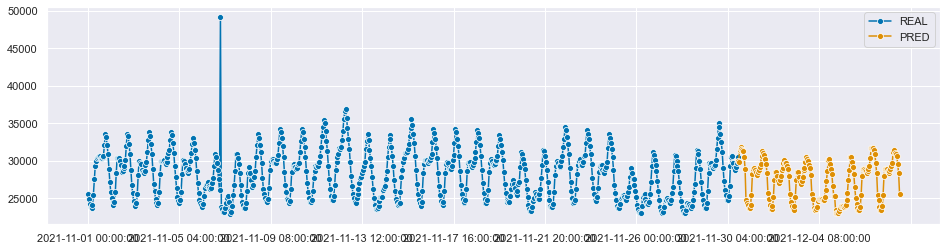

In [76]:
# Plotting predictions and past data
plot_series(df_h_Nov_21,forecasts_df, labels=["REAL", "PRED"])

Ahora obtengo unas prediciones que parecen muy buenas a simple vista, el modelo que se utiliza es un DatepartRegression model

Me quedo solo con las observaciones correspondientes a los primeros 7 días de diciembre

In [77]:
DiciembreAutots=forecasts_df[9:177].round(4)

In [78]:
DiciembreAutots

,y
2021-12-01 00:00:00,24717.7586
2021-12-01 01:00:00,24353.5816
2021-12-01 02:00:00,24141.6505
2021-12-01 03:00:00,23743.1554
2021-12-01 04:00:00,23656.0608
...,...
2021-12-07 19:00:00,31066.4490
2021-12-07 20:00:00,30953.9948
2021-12-07 21:00:00,30616.8065
2021-12-07 22:00:00,29577.2086


In [79]:
DhAutots=DiciembreAutots.head(10)

In [80]:
DiciembreAutots.to_csv("prediccioneshorariasautots.csv")

In [81]:
DhAutots.to_csv("prediccioneshorariasautotshead.csv")

# Datos diarios


Paso ahora a estudiar los datos diarios, decido en este caso trabajar con los datos correspondientes a los dos ultimos años

In [82]:
df_d_20_21=df_d.loc['2020':'2022']

Represento graficamente

<AxesSubplot:xlabel='ds'>

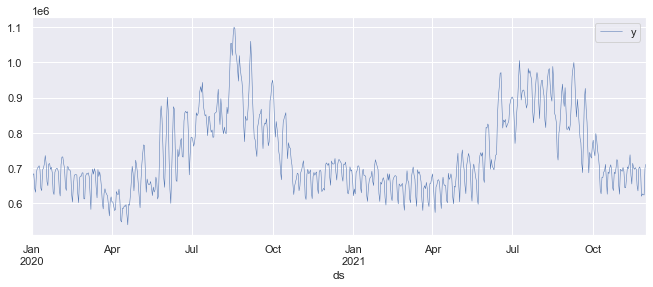

In [83]:
df_d_20_21.plot(linewidth=0.5)

Observamos que la serie es estacional, vamos a realizar la descomposición en componentes

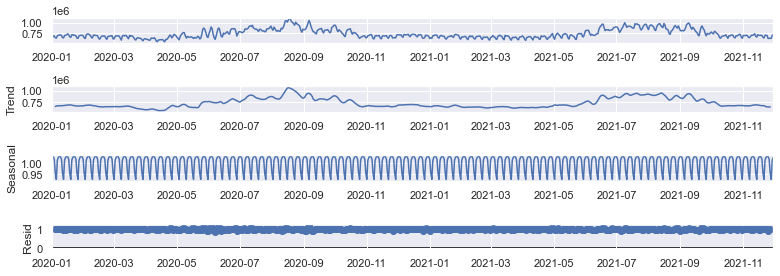

In [84]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(df_d_20_21, 
                                   model='multiplicative', 
                                   period=7)
decomposition.plot();

Al igual que en los datos horarios realizamos el test de Dickey-Fuller para estudiar la estacionariedad

In [85]:
adf=adfuller(df_d_20_21, maxlag=1)
print('El T-test es:', adf[0])

El T-test es: -6.458852048151234


In [86]:
print('El P-value es:', adf[1])
print('Valores críticos:', adf[4])

El P-value es: 1.460237522569679e-08
Valores críticos: {'1%': -3.439753311961436, '5%': -2.8656896390914217, '10%': -2.568979777013325}


Al igual que en los datos horarios,  nuestro valor T-test es mucho menos que los valores críticos y el p-valor es muy pequeño podemos decir que la serie es estacionaria y por tanto no seria necesario realizarle ninguna transformación a nuestros datos.
No obstante vamos a hacer la transformación a logaritmos por si obtenemos mejores predicciones como ocurria en el caso de los datos horarios.

In [87]:
# Apply Log Transformer
transformer = LogTransformer()
log_df_d_20_21= transformer.fit_transform(df_d_20_21)
log_df_d_20_21.tail()

,y
ds,
2021-11-26,13.345590
2021-11-27,13.342128
2021-11-28,13.340723
2021-11-29,13.457164
2021-11-30,13.472412


669 31


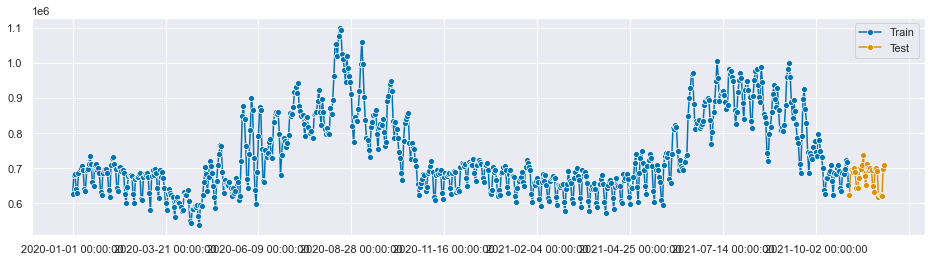

In [88]:
# Select Train & test sample
# we will try to forecast y_test from y_train
# plotting for illustration
# original and log samples
y_trainD, y_testD = temporal_train_test_split(y =df_d_20_21, test_size=31)
log_y_trainD, log_y_testD = temporal_train_test_split(y =log_df_d_20_21, test_size=31)
plot_series(y_trainD, y_testD, labels=["Train", "Test"])
# Time Series Size
print(y_trainD.shape[0], y_testD.shape[0])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

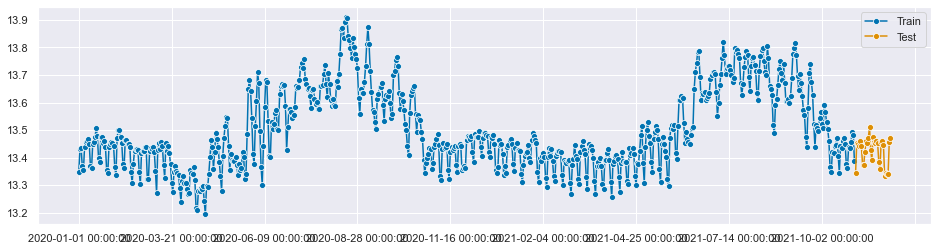

In [89]:
plot_series(log_y_trainD, log_y_testD, labels=["Train", "Test"])

## Modelo a batir: naïve estacional

Al igual que en el caso de los datos horarios elegimos el modelo naïve estacional como modelo base

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:88: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  if not hasattr(x, "freq") or x.freq is None:
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:90: FutureWarning: Timestamp.freq is deprecated and will be removed in a future version
  by *= x.freq
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

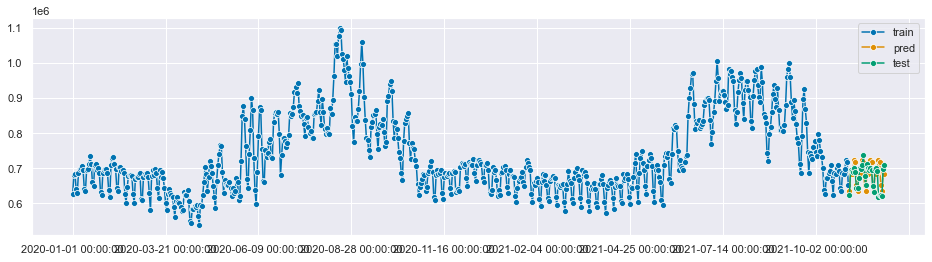

In [90]:
fhD= np.arange(len(y_testD)) + 1
# step 3: specifying the forecasting algorithm
forecasterD = NaiveForecaster(strategy="last", sp=7) #tomamos modelo naive estacional

# step 4: fitting the forecaster
forecasterD.fit(y_trainD)

# step 5: querying predictions
y_predNaiveD = forecasterD.predict(fhD)

# optional: plotting predictions and past data
plot_series(y_trainD, y_predNaiveD, y_testD, labels=["train","pred", "test"])

In [91]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_NAIVED=rmse(y_testD, y_predNaiveD)
# MAPE
MAPE_NAIVED=mean_absolute_percentage_error(y_testD, y_predNaiveD)
print(RMSE_NAIVED,MAPE_NAIVED)

29984.304709889202 0.029694861389665747


## AUTOARIMA

In [92]:
forecasterARIMAD = AutoARIMA(sp=7,suppress_warnings=True)
forecasterARIMAD.fit(y_trainD)

AutoARIMA(sp=7, suppress_warnings=True)

In [93]:
forecasterARIMADL= AutoARIMA(sp=7,suppress_warnings=True)
forecasterARIMADL.fit(log_y_trainD)

AutoARIMA(sp=7, suppress_warnings=True)

In [94]:
# Auto ARIMA Model Summary
print(forecasterARIMAD.summary())

                                     SARIMAX Results                                      
Dep. Variable:                                  y   No. Observations:                  669
Model:             SARIMAX(1, 1, 2)x(2, 0, [], 7)   Log Likelihood               -7864.151
Date:                            Sat, 15 Jan 2022   AIC                          15740.302
Time:                                    10:42:07   BIC                          15767.328
Sample:                                         0   HQIC                         15750.772
                                            - 669                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8413      0.031     26.729      0.000       0.780       0.903
ma.L1         -0.5845      0.035   

In [95]:
# Auto ARIMA Model Summary
print(forecasterARIMADL.summary())

                                       SARIMAX Results                                        
Dep. Variable:                                      y   No. Observations:                  669
Model:             SARIMAX(2, 1, 5)x(2, 0, [1, 2], 7)   Log Likelihood                1354.855
Date:                                Sat, 15 Jan 2022   AIC                          -2685.709
Time:                                        10:42:07   BIC                          -2631.658
Sample:                                             0   HQIC                         -2664.770
                                                - 669                                         
Covariance Type:                                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7004      0.539      1.299      0.194      -0.356       1.757
ar.

In [96]:
fhD = np.arange(len(y_testD)) + 1  # forecasting horizon

In [97]:
# Auto ARIMA Forecast
#Caso sin log
ARIMA_predD= forecasterARIMAD.predict(fhD)
ARIMA_predD

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,y
2021-10-31,626696.000586
2021-11-01,664836.765231
2021-11-02,666158.448787
2021-11-03,678850.081692
2021-11-04,690099.868264
2021-11-05,686098.309767
2021-11-06,655603.380484
2021-11-07,647877.466248
2021-11-08,675785.639913
2021-11-09,675844.328893


In [98]:
# Auto ARIMA Forecast
#caso log
log_y_predD = forecasterARIMADL.predict(fhD)
ARIMA_predDL=np.exp(log_y_predD)
ARIMA_predDL

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


,y
2021-10-31,620786.434989
2021-11-01,671233.767996
2021-11-02,681036.528546
2021-11-03,686884.085858
2021-11-04,690510.876775
2021-11-05,683702.502913
2021-11-06,639373.902746
2021-11-07,618946.715814
2021-11-08,669535.832898
2021-11-09,673807.963651


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

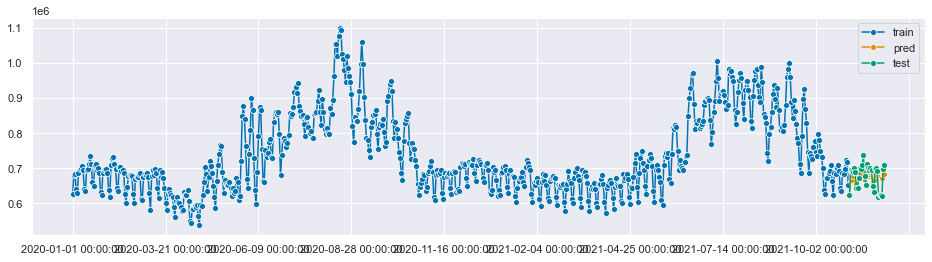

In [99]:
plot_series(y_trainD,ARIMA_predD,y_testD, labels=["train","pred", "test"])

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

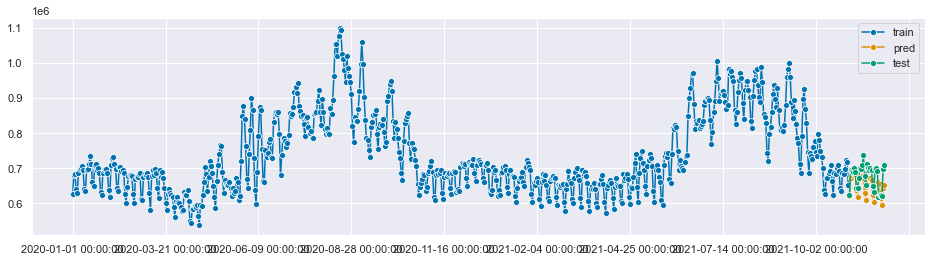

In [100]:
plot_series(y_trainD,ARIMA_predDL,y_testD, labels=["train","pred", "test"])

Vamos a ver que predicción es mejor

In [101]:
# Forecast Accuracy
#Root Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMAD=rmse(y_testD, ARIMA_predD)
RMSE_ARIMADL=rmse(y_testD, ARIMA_predDL)
print(RMSE_ARIMAD,RMSE_ARIMADL)

28831.47358922691 33532.40026610968


In [102]:
# Forecast Accuracy
# MAPE
MAPE_ARIMAD=mean_absolute_percentage_error(y_testD, ARIMA_predD)
MAPE_ARIMADL=mean_absolute_percentage_error(y_testD, ARIMA_predDL)
print(MAPE_ARIMAD,MAPE_ARIMADL)

0.032913968620116474 0.04322730104633959


En este caso obtenemos mejores resultados sin realizar la transformación logaritmica y por tanto tomamos ese modelo

## ETS

In [103]:
# specifying the forecasting algorithm
forecasterETSD= AutoETS(auto=True, sp=7)

In [104]:
y_trainD=y_trainD.astype('float64')

In [105]:
# Auto ETS Model Estimation
forecasterETSD.fit(y_trainD)

AutoETS(auto=True, sp=7)

In [106]:
print(forecasterETSD.summary())

                                 ETS Results                                  
Dep. Variable:                      y   No. Observations:                  669
Model:                       ETS(MNM)   Log Likelihood               -7741.013
Date:                Sat, 15 Jan 2022   AIC                          15504.025
Time:                        10:42:08   BIC                          15553.589
Sample:                    01-01-2020   HQIC                         15523.225
                         - 10-30-2021   Scale                            0.001
Covariance Type:               approx                                         
                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
smoothing_level        0.9999      0.050     20.039      0.000       0.902       1.098
smoothing_seasonal  1.035e-05      0.019      0.001      1.000      -0.038       0.038
initial_level       

In [107]:
# ETS Forescat
ETS_predD =forecasterETSD.predict(fhD)
print(ETS_predD)

                        y
2021-10-31  630887.677562
2021-11-01  691212.152211
2021-11-02  700916.367650
2021-11-03  703402.150873
2021-11-04  703144.418826
2021-11-05  694988.511777
2021-11-06  651363.908790
2021-11-07  630887.677562
2021-11-08  691212.152211
2021-11-09  700916.367650
2021-11-10  703402.150873
2021-11-11  703144.418826
2021-11-12  694988.511777
2021-11-13  651363.908790
2021-11-14  630887.677562
2021-11-15  691212.152211
2021-11-16  700916.367650
2021-11-17  703402.150873
2021-11-18  703144.418826
2021-11-19  694988.511777
2021-11-20  651363.908790
2021-11-21  630887.677562
2021-11-22  691212.152211
2021-11-23  700916.367650
2021-11-24  703402.150873
2021-11-25  703144.418826
2021-11-26  694988.511777
2021-11-27  651363.908790
2021-11-28  630887.677562
2021-11-29  691212.152211
2021-11-30  700916.367650


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

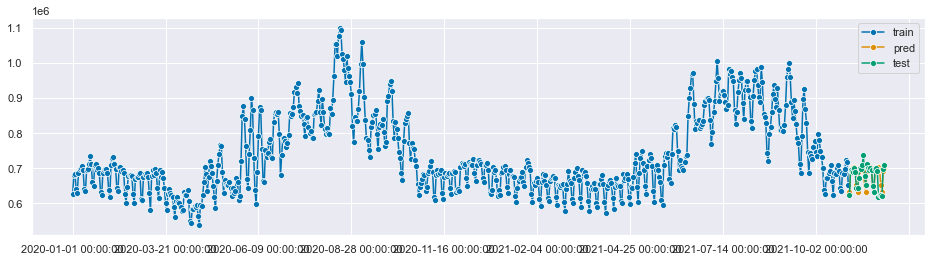

In [108]:
plot_series(y_trainD,ETS_predD,y_testD, labels=["train","pred", "test"] )

## PROPHET

In [35]:
df_d_20_21_p=df_d_20_21.rename_axis('ds').reset_index()

In [49]:
# Select Train & test sample
y_trainpD, y_testpD = temporal_train_test_split(y =df_d_20_21_p, test_size=60)

In [ ]:
from prophet import Prophet
mD = Prophet(daily_seasonality=True,yearly_seasonality=True)
mD.fit(y_trainpD)

In [ ]:
futureD = mD.make_future_dataframe(periods=len(y_testpD), freq='D')
forecastD = mD.predict(futureD)

In [ ]:
aD=df_d_20_21_p.shape[0]-60
predD=forecastD.loc[aD:,'yhat']

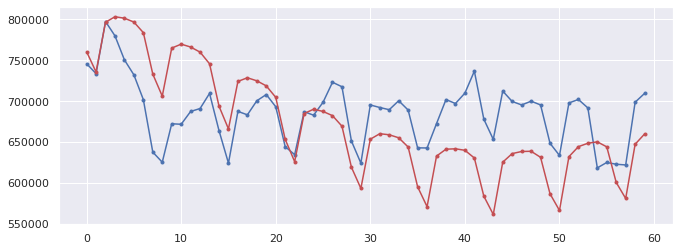

In [ ]:
plt.plot(list(y_testpD['y']),'.-')
plt.plot(list(predD),'r.-')
plt.show()

## Comparación técnicas

In [109]:
# Forecast Accuracy
#Mean Squared Error
rmse = MeanSquaredError(square_root=True)
RMSE_ARIMAD=rmse(y_testD, ARIMA_predD)
RMSE_ETSD=rmse(y_testD, ETS_predD)
print(RMSE_ARIMAD,RMSE_ETSD,RMSE_NAIVED)

28831.47358922691 23951.02472761023 29984.304709889202


In [110]:
# Forecast Accuracy
# MAPE
MAPE_ARIMAD=mean_absolute_percentage_error(y_testD, ARIMA_predD)
MAPE_ETSD=mean_absolute_percentage_error(y_testD, ETS_predD)
print(MAPE_ARIMAD,MAPE_ETSD,MAPE_NAIVED)

0.032913968620116474 0.021771353258885396 0.029694861389665747


In [ ]:
# Forecast Accuracy
RMSE_ProphetD=rmse(list(y_testpD['y']), list(predD))
MAPE_ProphetD=mean_absolute_percentage_error(list(y_testpD['y']),list(predD))
print(RMSE_ProphetD,MAPE_ProphetD)

54769.06514327974 0.07070984843012694


Nos quedamos con ETS pues es el método con el que obtenemos menor error

 ## Predicciones Diarias 15 días Dic21

In [111]:
df_d_20_21=df_d_20_21.astype('float64')

In [112]:
# ETS Model
fh = np.arange(1, 15+1)
forecasterETSD.fit(df_d_20_21)
DIC_predD = forecasterETSD.predict(fh).round(4)
print(DIC_predD)

                      y
2021-12-01  711712.7248
2021-12-02  711035.2463
2021-12-03  703271.5141
2021-12-04  659341.0542
2021-12-05  638934.3987
2021-12-06  699973.5031
2021-12-07  709567.8965
2021-12-08  711712.7248
2021-12-09  711035.2463
2021-12-10  703271.5141
2021-12-11  659341.0542
2021-12-12  638934.3987
2021-12-13  699973.5031
2021-12-14  709567.8965
2021-12-15  711712.7248


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:65: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  if hasattr(x, "freqstr"):
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sktime\utils\datetime.py:66: FutureWarning: Timestamp.freqstr is deprecated and will be removed in a future version.
  return x.freqstr


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

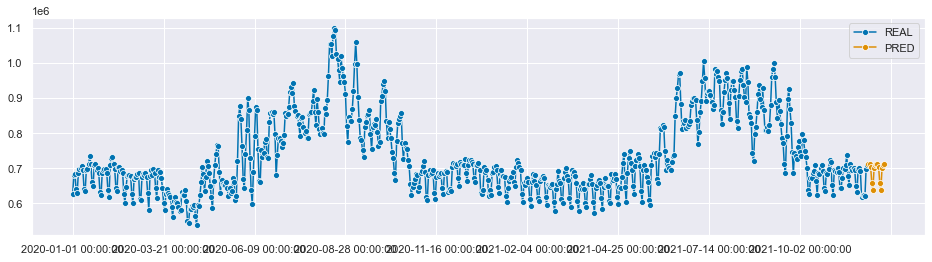

In [113]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(df_d_20_21,DIC_predD, labels=["REAL", "PRED"])

Ploteamos unicamente 2021 para ver mejor las predicciones

(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

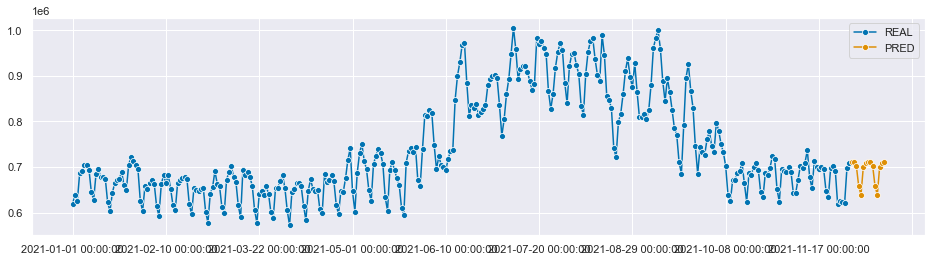

In [114]:
# Forecast Accuracy Plot
# Plotting predictions and past data
plot_series(df_d_20_21.loc['2021'],DIC_predD, labels=["REAL", "PRED"])

A simple vista parece que las predicciones que obtenemos son bastante buenas

In [115]:
DIC_predD.to_csv("prediccionesdiarias.csv")

### Anexo: AutoTS

In [158]:
df = df_d_20_21
metric_weighting = {
    'smape_weighting': 1,
    'mae_weighting': 0,
    'rmse_weighting': 1,
    'made_weighting': 0,
    'containment_weighting': 0,
    'runtime_weighting': 0,
    'spl_weighting': 0,
    'contour_weighting': 0,
}
model = AutoTS(
    forecast_length=16,
    frequency='D',
    prediction_interval=0.9,
    ensemble=None,
    model_list="fast",  # "superfast", "default", "fast_parallel"
    transformer_list="fast",  # "superfast",
    drop_most_recent=1,
    no_negatives=True,
    max_generations=6,
    num_validations=3,
    metric_weighting=metric_weighting,
    validation_method="seasonal 364"
)
model = model.fit(df)
prediction = model.predict()

Model Number: 1 with model AverageValueNaive in generation 0 of 6
Model Number: 2 with model AverageValueNaive in generation 0 of 6
Model Number: 3 with model AverageValueNaive in generation 0 of 6
Model Number: 4 with model DatepartRegression in generation 0 of 6
Model Number: 5 with model DatepartRegression in generation 0 of 6
Model Number: 6 with model DatepartRegression in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 7 with model DatepartRegression in generation 0 of 6
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 7: DatepartRegression
Model Number: 8 with model ETS in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 9 with model ETS in generation 0 of 6
Model Number: 10 with model GLM in generation 0 of 6
Model Number: 11 with model GLM in generation 0 of 6
Model Number: 12 with model GLS in generation 0 of 6
Model Number: 13 with model GLS in generation 0 of 6
Model Number: 14 with model LastValueNaive in generation 0 of 6
Model Number: 15 with model LastValueNaive in generation 0 of 6
Model Number: 16 with model LastValueNaive in generation 0 of 6
Model Number: 17 with model LastValueNaive in generation 0 of 6
Model Number: 18 with model SeasonalNaive in generation 0 of 6
Model Number: 19 with model SeasonalNaive in generation 0 of 6
Model Number: 20 with model SeasonalNaive in generation 0 of 6
Model Number: 21 with model SeasonalNaive in generation 0 of 6
Model Number: 22 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 22: VAR
Model Number: 23 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only ga

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 35 with model SeasonalNaive in generation 0 of 6
Model Number: 36 with model GLM in generation 0 of 6
Model Number: 37 with model ETS in generation 0 of 6
Model Number: 38 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 38: VAR
Model Number: 39 with model VECM in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 39: VECM
Model Number: 40 with model WindowRegression in generation 0 of 6
Model Number: 41 with model DatepartRegression in generation 0 of 6
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 41: DatepartRegression
Model Number: 42 with model UnivariateMotif in generation 0 of 6
Model Number: 43 with model MultivariateMotif in generation 0 of 6
Model Number: 44 with model SectionalMotif in generation 0 of 6
Model Number: 45 with model NVAR in generation 0 of 6
Model Number: 46 with model GLM in generati

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Number: 56 with model MultivariateMotif in generation 0 of 6
Model Number: 57 with model GLS in generation 0 of 6


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    1.1s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Model Number: 58 with model WindowRegression in generation 0 of 6
Model Number: 59 with model MultivariateMotif in generation 0 of 6
Model Number: 60 with model LastValueNaive in generation 0 of 6
Model Number: 61 with model SectionalMotif in generation 0 of 6
Model Number: 62 with model ZeroesNaive in generation 0 of 6
Model Number: 63 with model GLM in generation 0 of 6
Template Eval Error: ValueError('NaN, inf or invalid value detected in weights, estimation infeasible.') in model 63: GLM
Model Number: 64 with model VAR in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 64: VAR
Model Number: 65 with model ZeroesNaive in generation 0 of 6
Model Number: 66 with model GLM in generation 0 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 66: GLM
Model Number: 67 with model NVAR in generation 0 of 6
Model Number: 68 with model WindowRegression in generation 0 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:426: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:132: RuntimeWarning: divide by zero encountered in true_divide
  return 1. / (self.link.deriv(mu)**2 * self.variance(mu))


Model Number: 69 with model WindowRegression in generation 0 of 6
Model Number: 70 with model WindowRegression in generation 0 of 6
Model Number: 71 with model GLM in generation 0 of 6
Model Number: 72 with model MultivariateMotif in generation 0 of 6
Model Number: 73 with model NVAR in generation 0 of 6
Model Number: 74 with model VECM in generation 0 of 6
Template Eval Error: ValueError('Only gave one variable to VECM') in model 74: VECM
Model Number: 75 with model AverageValueNaive in generation 0 of 6
Model Number: 76 with model AverageValueNaive in generation 0 of 6
Model Number: 77 with model VECM in generation 0 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor supplied") in model 77: VECM
Model Number: 78 with model SectionalMotif in generation 0 of 6
Model Number: 79 with model GLM in generation 0 of 6
Model Number: 80 with model UnivariateMotif in generation 0 of 6
Model Number: 81 with model LastValueNaive in generation 0 of 6
Model Number:

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:692: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (1000) reached and the optimization hasn't converged yet.
  warnings.warn(


Model Number: 109 with model MultivariateMotif in generation 1 of 6
Model Number: 110 with model MultivariateMotif in generation 1 of 6
Model Number: 111 with model MultivariateMotif in generation 1 of 6
Model Number: 112 with model MultivariateMotif in generation 1 of 6
Model Number: 113 with model UnivariateMotif in generation 1 of 6
Model Number: 114 with model UnivariateMotif in generation 1 of 6
Model Number: 115 with model UnivariateMotif in generation 1 of 6
Model Number: 116 with model UnivariateMotif in generation 1 of 6
Model Number: 117 with model AverageValueNaive in generation 1 of 6
Model Number: 118 with model AverageValueNaive in generation 1 of 6
Model Number: 119 with model AverageValueNaive in generation 1 of 6
Model Number: 120 with model GLS in generation 1 of 6
Model Number: 121 with model GLS in generation 1 of 6
Model Number: 122 with model GLS in generation 1 of 6
Model Number: 123 with model LastValueNaive in generation 1 of 6
Model Number: 124 with model Last

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Model Number: 135 with model ETS in generation 1 of 6
Model Number: 136 with model ETS in generation 1 of 6
Model Number: 137 with model WindowRegression in generation 1 of 6
Model Number: 138 with model WindowRegression in generation 1 of 6
Model Number: 139 with model WindowRegression in generation 1 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 139: WindowRegression
Model Number: 140 with model NVAR in generation 1 of 6
Model Number: 141 with model NVAR in generation 1 of 6
Model Number: 142 with model NVAR in generation 1 of 6
Model Number: 143 with model NVAR in generation 1 of 6
Model Number: 144 with model ZeroesNaive in generation 1 of 6
Model Number: 145 with model ZeroesNaive in generation 1 of 6
Model Number: 146 with model ZeroesNaive in generation 1 of 6
Model Number: 147 with model SectionalMotif in generation 1 of 6
Model Number: 148 with model SectionalMotif in generation 1 of 6
Model Number: 149 with model Sectio

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neural_network\_multilayer_perceptron.py:549: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
  self.n_iter_ = _check_optimize_result("lbfgs", opt_res, self.max_iter)


Model Number: 180 with model GLS in generation 2 of 6
Template Eval Error: ValueError('zero-size array to reduction operation maximum which has no identity') in model 180: GLS
Model Number: 181 with model GLS in generation 2 of 6
Model Number: 182 with model GLS in generation 2 of 6
Model Number: 183 with model LastValueNaive in generation 2 of 6
Model Number: 184 with model LastValueNaive in generation 2 of 6
Model Number: 185 with model LastValueNaive in generation 2 of 6
Model Number: 186 with model GLM in generation 2 of 6
Model Number: 187 with model GLM in generation 2 of 6
Template Eval Error: ValueError('The first guess on the deviance function returned a nan.  This could be a boundary  problem and should be reported.') in model 187: GLM
Model Number: 188 with model GLM in generation 2 of 6
Model Number: 189 with model GLM in generation 2 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)


Template Eval Error: ValueError('Length mismatch: Expected axis has 1 elements, new values have 684 elements') in model 189: GLM
Model Number: 190 with model ETS in generation 2 of 6
Model Number: 191 with model ETS in generation 2 of 6
Model Number: 192 with model ETS in generation 2 of 6
Model Number: 193 with model ETS in generation 2 of 6
Model Number: 194 with model NVAR in generation 2 of 6
Model Number: 195 with model NVAR in generation 2 of 6
Model Number: 196 with model NVAR in generation 2 of 6
Model Number: 197 with model NVAR in generation 2 of 6
Model Number: 198 with model ZeroesNaive in generation 2 of 6
Model Number: 199 with model ZeroesNaive in generation 2 of 6
Model Number: 200 with model ZeroesNaive in generation 2 of 6
Model Number: 201 with model SectionalMotif in generation 2 of 6
Model Number: 202 with model SectionalMotif in generation 2 of 6
Model Number: 203 with model SectionalMotif in generation 2 of 6
Model Number: 204 with model SectionalMotif in generat

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Model Number: 219 with model SectionalMotif in generation 3 of 6
Model Number: 220 with model SectionalMotif in generation 3 of 6
Model Number: 221 with model SectionalMotif in generation 3 of 6
Model Number: 222 with model SectionalMotif in generation 3 of 6
Model Number: 223 with model UnivariateMotif in generation 3 of 6
Model Number: 224 with model UnivariateMotif in generation 3 of 6


[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    4.3s finished
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 1000 out of 1000 | elapsed:    0.0s finished


Model Number: 225 with model UnivariateMotif in generation 3 of 6
Model Number: 226 with model UnivariateMotif in generation 3 of 6
Model Number: 227 with model MultivariateMotif in generation 3 of 6
Model Number: 228 with model MultivariateMotif in generation 3 of 6
Model Number: 229 with model MultivariateMotif in generation 3 of 6
Model Number: 230 with model MultivariateMotif in generation 3 of 6
Model Number: 231 with model SeasonalNaive in generation 3 of 6
Model Number: 232 with model SeasonalNaive in generation 3 of 6
Model Number: 233 with model SeasonalNaive in generation 3 of 6
Model Number: 234 with model SeasonalNaive in generation 3 of 6
Model Number: 235 with model AverageValueNaive in generation 3 of 6
Model Number: 236 with model AverageValueNaive in generation 3 of 6
Model Number: 237 with model AverageValueNaive in generation 3 of 6
Model Number: 238 with model GLS in generation 3 of 6
Model Number: 239 with model GLS in generation 3 of 6
Model Number: 240 with model

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\lib\nanfunctions.py:1389: RuntimeWarning: All-NaN slice encountered
  result = np.apply_along_axis(_nanquantile_1d, axis, a, q,


Model Number: 246 with model GLM in generation 3 of 6
Model Number: 247 with model GLM in generation 3 of 6
Model Number: 248 with model ETS in generation 3 of 6
Model Number: 249 with model ETS in generation 3 of 6
Model Number: 250 with model ETS in generation 3 of 6
Model Number: 251 with model NVAR in generation 3 of 6
Model Number: 252 with model NVAR in generation 3 of 6
Model Number: 253 with model NVAR in generation 3 of 6
Model Number: 254 with model NVAR in generation 3 of 6
Model Number: 255 with model ZeroesNaive in generation 3 of 6
Model Number: 256 with model ZeroesNaive in generation 3 of 6
Model Number: 257 with model ZeroesNaive in generation 3 of 6
Model Number: 258 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 258: VAR
Model Number: 259 with model VAR in generation 3 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 259: VAR
Model Number: 260 with model VAR in generation 3 o

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\

[LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear][LibLinear]Model Number: 278 with model DatepartRegression in generation 4 of 6
Template Eval Error: ImportError('Tensorflow not available, install with pip install tensorflow.') in model 278: DatepartRegression
Model Number: 279 with model DatepartRegression in generation 4 of 6


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 280 with model WindowRegression in generation 4 of 6
Template Eval Error: ValueError("regression_type='User' but no future_regressor passed") in model 280: WindowRegression
Model Number: 281 with model WindowRegression in generation 4 of 6
Template Eval Error: ValueError('`min_samples` may not be larger than number of samples: n_samples = 304.') in model 281: WindowRegression
Model Number: 282 with model WindowRegression in generation 4 of 6
Model Number: 283 with model SeasonalNaive in generation 4 of 6
Model Number: 284 with model SeasonalNaive in generation 4 of 6
Template Eval Error: ValueError("Input contains NaN, infinity or a value too large for dtype('float64').") in model 284: SeasonalNaive
Model Number: 285 with model SeasonalNaive in generation 4 of 6
Model Number: 286 with model SeasonalNaive in generation 4 of 6
Model Number: 287 with model AverageValueNaive in generation 4 of 6
Model Number: 288 with model AverageValueNaive in generation 4 of 6
Model Number:

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\generalized_linear_model.py:298: DomainWarning: The inverse_power link function does not respect the domain of the Gamma family.
  warnings.warn((f"The {type(family.link).__name__} link function "


Model Number: 301 with model ETS in generation 4 of 6
Model Number: 302 with model ETS in generation 4 of 6
Model Number: 303 with model ETS in generation 4 of 6
Model Number: 304 with model ZeroesNaive in generation 4 of 6
Model Number: 305 with model ZeroesNaive in generation 4 of 6
Model Number: 306 with model ZeroesNaive in generation 4 of 6
Model Number: 307 with model NVAR in generation 4 of 6
Model Number: 308 with model NVAR in generation 4 of 6
Model Number: 309 with model NVAR in generation 4 of 6
Model Number: 310 with model NVAR in generation 4 of 6
Model Number: 311 with model VAR in generation 4 of 6
Template Eval Error: IndexError('tuple index out of range') in model 311: VAR
Model Number: 312 with model VAR in generation 4 of 6
Template Eval Error: IndexError('tuple index out of range') in model 312: VAR
Model Number: 313 with model VAR in generation 4 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 313: VAR
Model Number: 314 with model VE

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
C:\Users\malon\

Model Number: 335 with model SeasonalNaive in generation 5 of 6
Model Number: 336 with model SeasonalNaive in generation 5 of 6
Model Number: 337 with model SeasonalNaive in generation 5 of 6
Model Number: 338 with model AverageValueNaive in generation 5 of 6
Model Number: 339 with model AverageValueNaive in generation 5 of 6
Model Number: 340 with model AverageValueNaive in generation 5 of 6
Model Number: 341 with model GLS in generation 5 of 6
Model Number: 342 with model GLS in generation 5 of 6
Model Number: 343 with model GLS in generation 5 of 6
Model Number: 344 with model LastValueNaive in generation 5 of 6
Model Number: 345 with model LastValueNaive in generation 5 of 6
Model Number: 346 with model LastValueNaive in generation 5 of 6
Model Number: 347 with model GLM in generation 5 of 6
Template Eval Error: ValueError('regression_type=user and no future_regressor passed') in model 347: GLM
Model Number: 348 with model GLM in generation 5 of 6
Template Eval Error: ValueError('r

C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1342: RuntimeWarning: divide by zero encountered in true_divide
  endog_mu = self._clean(endog / mu)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: invalid value encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\links.py:516: RuntimeWarning: overflow encountered in exp
  return np.exp(z)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\statsmodels\genmod\families\family.py:1346: RuntimeWarning: divide by zero encountered in log
  resid_dev -= endog_alpha * np.log(endog_alpha / mu_alpha)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\numpy\core\fromnumeric.py:87: RuntimeWarning: invalid value encountered in reduce
  return ufunc.reduce(obj, 

Model Number: 353 with model ETS in generation 5 of 6
Model Number: 354 with model ETS in generation 5 of 6
Model Number: 355 with model ZeroesNaive in generation 5 of 6
Model Number: 356 with model ZeroesNaive in generation 5 of 6
Model Number: 357 with model NVAR in generation 5 of 6
Model Number: 358 with model NVAR in generation 5 of 6
Model Number: 359 with model NVAR in generation 5 of 6
Model Number: 360 with model NVAR in generation 5 of 6
Model Number: 361 with model VAR in generation 5 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 361: VAR
Model Number: 362 with model VAR in generation 5 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 362: VAR
Model Number: 363 with model VAR in generation 5 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 363: VAR
Model Number: 364 with model VAR in generation 5 of 6
Template Eval Error: ValueError('Only gave one variable to VAR') in model 364: VAR


C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\base.py:441: UserWarning: X does not have valid feature names, but RadiusNeighborsRegressor was fitted with feature names
  warnings.warn(
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\neighbors\_regression.py:474: UserWarning: One or more samples have no neighbors within specified radius; predicting NaN.
  warnings.warn(empty_warning_msg)
C:\Users\malon\anaconda3\envs\tecnicas_prediccion\lib\site-packages\sklearn\svm\_base.py:1199: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Model Number: 386 with model SeasonalNaive in generation 6 of 6
Model Number: 387 with model SeasonalNaive in generation 6 of 6
Model Number: 388 with model SeasonalNaive in generation 6 of 6
Model Number: 389 with model SeasonalNaive in generation 6 of 6
Model Number: 390 with model AverageValueNaive in generation 6 of 6
Model Number: 391 with model AverageValueNaive in generation 6 of 6
Model Number: 392 with model AverageValueNaive in generation 6 of 6
Model Number: 393 with model NVAR in generation 6 of 6
Model Number: 394 with model NVAR in generation 6 of 6
Model Number: 395 with model NVAR in generation 6 of 6
Model Number: 396 with model NVAR in generation 6 of 6
Model Number: 397 with model GLS in generation 6 of 6
Model Number: 398 with model GLS in generation 6 of 6
Model Number: 399 with model GLS in generation 6 of 6
Model Number: 400 with model LastValueNaive in generation 6 of 6
Model Number: 401 with model GLM in generation 6 of 6
Model Number: 402 with model GLM in gen

In [159]:
# Print the details of the best model
print(model)
# point forecasts dataframe
forecasts_df = prediction.forecast
# accuracy of all tried model results
model_results = model.results()

Initiated AutoTS object with best model: 
MultivariateMotif
{'fillna': 'mean', 'transformations': {'0': 'ClipOutliers', '1': 'QuantileTransformer'}, 'transformation_params': {'0': {'method': 'clip', 'std_threshold': 3, 'fillna': None}, '1': {'output_distribution': 'uniform', 'n_quantiles': 227}}}
{'window': 10, 'point_method': 'mean', 'distance_metric': 'braycurtis', 'k': 3, 'max_windows': 10000}


In [160]:
forecasts_df

,y
2021-11-30,709389.191647
2021-12-01,714629.737109
2021-12-02,710998.023597
2021-12-03,710847.802745
2021-12-04,662492.965891
2021-12-05,645994.313327
2021-12-06,706500.869389
2021-12-07,722724.103742
2021-12-08,709291.651319
2021-12-09,710370.007050


(<Figure size 1152x288 with 1 Axes>, <AxesSubplot:>)

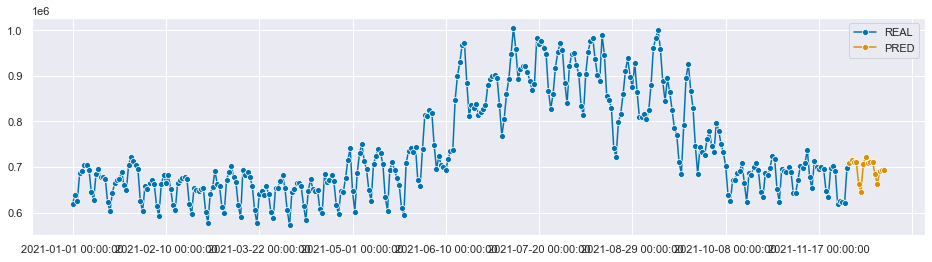

In [161]:
plot_series(df_d_20_21.loc['2021'],forecasts_df, labels=["REAL", "PRED"])

El modelo elegido en este caso es el MultivariateMotif

In [162]:
DECDAutots=forecasts_df[1:].round(4) #tomamos los datos de los primeros 15 días de diciembre

In [163]:
DECDAutots

,y
2021-12-01,714629.7371
2021-12-02,710998.0236
2021-12-03,710847.8027
2021-12-04,662492.9659
2021-12-05,645994.3133
2021-12-06,706500.8694
2021-12-07,722724.1037
2021-12-08,709291.6513
2021-12-09,710370.0071
2021-12-10,711130.3477


In [164]:
DECDAutots.to_csv("prediccionesdiariasautots.csv")